In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load data


In [2]:
video = cv2.VideoCapture(os.path.join("..", "data", "raw", "train", "1606b0e6_0.mp4"))
df = pd.read_csv(os.path.join("..", "data", "raw", "train.csv"))

In [3]:
df = df[~df["event"].isin(["start", "end"])]
df

,video_id,time,event,event_attributes
1,1606b0e6_0,201.150,challenge,['ball_action_forced']
4,1606b0e6_0,210.870,challenge,['opponent_dispossessed']
7,1606b0e6_0,219.230,throwin,['pass']
10,1606b0e6_0,224.430,play,"['pass', 'openplay']"
13,1606b0e6_0,229.390,play,"['pass', 'openplay']"
...,...,...,...,...
11206,ecf251d4_0,3041.347,play,"['pass', 'openplay']"
11209,ecf251d4_0,3050.347,play,"['pass', 'openplay']"
11210,ecf251d4_0,3053.067,play,"['pass', 'openplay']"
11213,ecf251d4_0,3056.587,challenge,['opponent_dispossessed']


In [4]:
a1 = df['time'].to_numpy()[:-1]
a2 = df['time'].to_numpy()[1:]

np.abs(a2 - a1).min()

0.7199999999997999

In [5]:
video.set(cv2.CAP_PROP_POS_MSEC, 201.150000 * 1000)

ret, frame = video.read()
video.get(cv2.CAP_PROP_POS_FRAMES)

5030.0

In [6]:
fps = video.get(cv2.CAP_PROP_FPS)
frame_number = int(fps * 201.150000)
video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

ret, frame2 = video.read()
video.get(cv2.CAP_PROP_POS_FRAMES)

5029.0

In [7]:
from src.data.processing import extract_frames, save_frames

frames = extract_frames(video, 201, 16)

In [8]:
save_frames(frames, 32, '../data/processed/test.mp4')

AttributeError: 'list' object has no attribute 'shape'

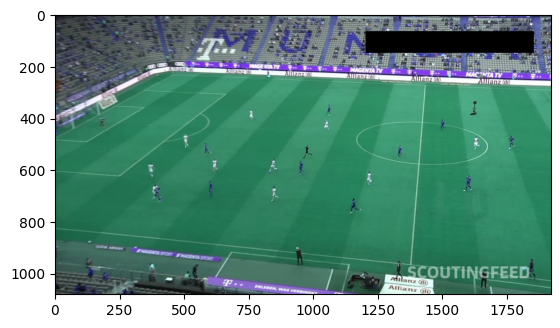

In [ ]:
plt.imshow(frame)

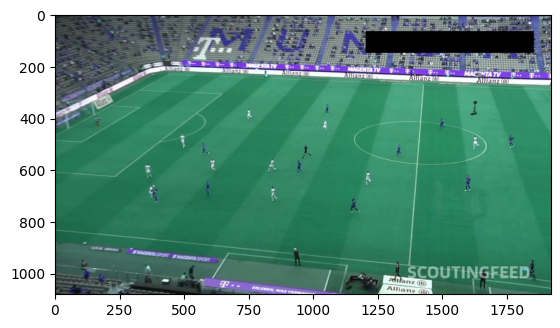

In [ ]:
plt.imshow(frame2)

# Explore videos

In [9]:
import torchvision
import os
# torchvision.set_video_backend("video_reader")

video_path = os.path.join("..", "data", "raw", "train", "1606b0e6_0.mp4")

In [10]:
video = torchvision.io.VideoReader(video_path, 'video')

AttributeError: 'ImportError' object has no attribute 'open'

# Create data loaders

In [2]:
import pandas as pd


df = pd.read_csv(os.path.join("..", "data", "processed", "labels.csv"))

In [3]:
df.head()

,video_id,clip_id,time,event
0,1606b0e6_0,1606b0e6_0_0,201.15,challenge
1,1606b0e6_0,1606b0e6_0_1,210.87,challenge
2,1606b0e6_0,1606b0e6_0_2,219.23,throwin
3,1606b0e6_0,1606b0e6_0_3,224.43,play
4,1606b0e6_0,1606b0e6_0_4,229.39,play


In [4]:
df['video_id'].value_counts()

1606b0e6_1    840
3c993bd2_0    747
35bd9041_0    744
1606b0e6_0    729
ecf251d4_0    719
3c993bd2_1    709
35bd9041_1    692
407c5a9e_1    683
cfbe2e94_0    638
4ffd5986_0    635
9a97dae4_1    624
cfbe2e94_1    618
Name: video_id, dtype: int64

In [2]:
from src.data.datasets import DFLDataset, train_test_split
from src.data.transformations import VideoToTensor, VideoResize
from torchvision import transforms


In [3]:
transformations = transforms.Compose([VideoToTensor(), VideoResize(size=(180, 320))])

dfl = DFLDataset(
    data_dir="../data/processed/",
    video_transform=transformations,
    label_transform=transforms.ToTensor(),
    size=100
)

In [4]:
len(dfl)

100

In [11]:
train_dataset, test_dataset = train_test_split(dfl, 2)

In [12]:
len(train_dataset), len(test_dataset)

(6976, 1402)

In [10]:
from src.data.data_modules import DFLDataModule

train_dataloader = DFLDataModule(data_dir="../data/processed/", size=100)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))

In [12]:
train_dataloader.setup('test')

# Create a model

In [13]:
clip, label = train_dataset[0]
input = clip

In [ ]:
input.shape

torch.Size([33, 3, 540, 960])

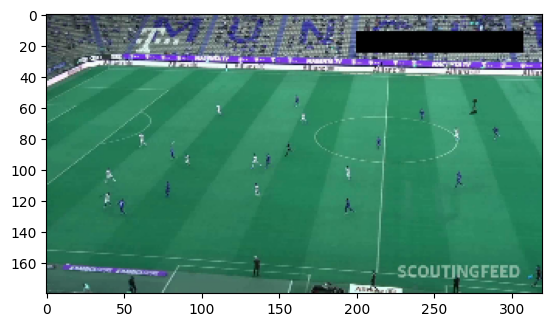

In [15]:
plt.imshow(input[0].permute(1, 2, 0))

In [12]:
import torch
from torch import nn
from torchvision import transforms, models

In [13]:
r3d = models.video.r3d_18(weights=models.video.R3D_18_Weights.KINETICS400_V1)

In [15]:
r3d.fc = nn.Linear(in_features=512, out_features=4)
r3d

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [18]:
y_hat = r3d(input.permute(1, 0, 2, 3).unsqueeze(0))
y_hat

tensor([[-6.4500e-01,  9.8488e-02, -3.1693e-04,  2.6601e-02]],
       grad_fn=<AddmmBackward0>)